In [1]:
import os
import torch
import numpy as np
import netCDF4 as nc
from torch.utils.data import Dataset, DataLoader
from datetime import datetime
import torch.optim as optim
import dataset as windData
from tqdm import tqdm
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wandb config
import wandb
os.environ["WANDB_ENTITY"]="WindDownscaling"

In [2]:
in_data, out_data = windData.make_clean_data(['u10', 'v10'], 2010, 2020)
u10 = in_data[:,:,:,0]
v10 = in_data[:,:,:,1]
in_data = np.sqrt(np.square(u10) + np.square(v10))

#normalize the data
in_max, in_min = (np.max(in_data), np.min(in_data))
in_data = (in_data-in_max)/(in_max-in_min)

out_max, out_min = (np.max(out_data), np.min(out_data))
out_data = (out_data-out_max)/(out_max-out_min)

train_idx, val_idx, test_idx = windData.spliting_indices(len(in_data), val_pct=0.10, test_pct=0.10)

# Diviser le dataset en trois pour que ce soit propre.

train_dataset = windData.DownscalingDataset(in_data, out_data, low_var_name='uv10', high_var_name='si10', indices=train_idx)
test_dataset = windData.DownscalingDataset(in_data, out_data, low_var_name='uv10', high_var_name='si10', indices=val_idx)
val_dataset = windData.DownscalingDataset(in_data, out_data, low_var_name='uv10', high_var_name='si10', indices= test_idx)

train_dataset.get_var_name()
print(len(train_dataset))
print(len(test_dataset))
print(train_dataset[0]["low_res"].shape)
print(train_dataset[0]["high_res"].shape)

0 29216
Low res variable name:  uv10
High res variable name:  si10
23374
2921
(13, 21)
(63, 62)


In [3]:
T = 20
min_noise = 0.015
max_noise = 0.95

In [4]:
# From youtube tutorial. Could be re-implemented but seems good to me

import torch.nn.functional as F

def linear_beta_schedule(timesteps, start, end):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """
    Takes an image and a timestep as input and
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# Define beta schedule
betas = linear_beta_schedule(timesteps=T, start=min_noise, end=max_noise)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0) # don't know why we need that
sqrt_recip_alphas = torch.sqrt(1.0 / alphas) # don't know why we need that
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod) # don't know why we need that

In [5]:
##########################################################################################
# Let's define the Unet
##########################################################################################

In [5]:
import torch.nn as nn

In [6]:
# This is used to get embedding of time step t to provide it as input to the model
# so that it knows how much noise it needs to remove
# Copy/pasted from the youtube video but it seems to be the same as the one we saw in class

import math

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time): # idk if they use the same embedding in the paper's model
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)

        return embeddings

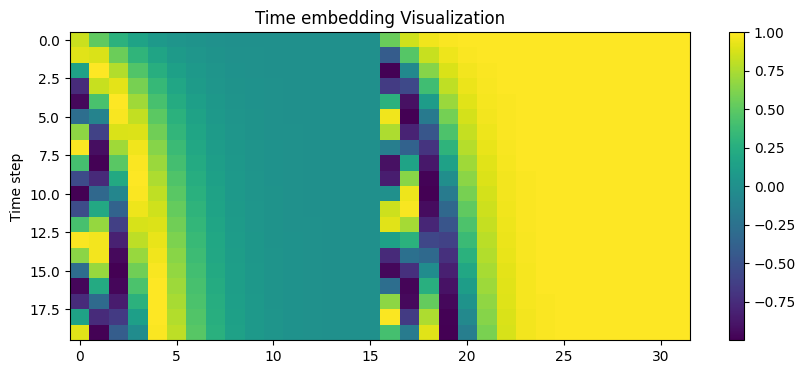

In [7]:
# Illustrating the embeddings:
import matplotlib.pyplot as plt

all_t = torch.arange(1, T+1)
test_embed = SinusoidalPositionEmbeddings(dim=32)
output = test_embed(all_t)

plt.figure(figsize=(10,4))
plt.imshow(output, cmap='viridis', aspect='auto')
plt.colorbar()
plt.title('Time embedding Visualization')
plt.ylabel('Time step')
plt.show()


In [9]:
class DownBlock(nn.Module):
    '''Downsampling block used to build Unet'''
    def __init__(self, in_ch, out_ch, drop_p, time_emb_dim):
        super().__init__()

        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding='same')
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding='same')

        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)

        self.drop = nn.Dropout(p=drop_p)

        self.relu = nn.ReLU()

        self.avgpool = nn.AvgPool2d(kernel_size=6, padding=2, stride=2)

        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)

    def forward(self, x, t):
        h = self.bnorm1(self.relu(self.conv1(x)))

        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb

        h = self.bnorm2(self.relu(self.conv2(h)))

        h = self.avgpool(h)

        h = self.drop(h)     # not sure we wanna use dropout

        return h

In [10]:
class UpBlock(nn.Module):
    '''Upampling block used to build Unet'''
    def __init__(self, in_ch, out_ch, drop_p, time_emb_dim, shape):
        super().__init__()

        self.upsamp = nn.Upsample(size=shape, mode='bilinear')

        # 2*in_ch because residual connection
        self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding='same')
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding='same')

        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)

        self.drop = nn.Dropout(p=drop_p)

        self.relu = nn.ReLU()

        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)


    def forward(self, x, t):
        h = self.upsamp(x)

        h = self.drop(h)     # not sure we wanna use dropout

        h = self.bnorm1(self.relu(self.conv1(h)))

        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb

        h = self.bnorm2(self.relu(self.conv2(h)))

        return h

In [11]:
class Bottleneck(nn.Module):
    '''Bottleneck block used to build Unet'''
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super().__init__()

        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)

        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding='same')
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding='same')

        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)

        self.relu = nn.ReLU()


    def forward(self, x, t):
        h = self.bnorm1(self.relu(self.conv1(x)))

        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb

        h = self.bnorm2(self.relu(self.conv2(h)))

        return h

In [12]:
class DenoisingUnet(nn.Module):
    '''Unet architecture denoising model'''
    def __init__(self, nbr_channels, input_channels, output_channels, time_emb_dim, shape):
        super().__init__()
        self.down_channels = tuple(nbr_channels)
        self.up_channels = tuple(nbr_channels[::-1])

        # Not sure this is the right way to combine the blocks but I think so because
        # they say they have 4 blocks on each side and they give 4 different numbers of
        # channels

        self.down0 = DownBlock(input_channels, self.down_channels[0], 0.5, time_emb_dim)

        self.downs = nn.ModuleList([DownBlock(self.down_channels[i], self.down_channels[i+1], 0.5, time_emb_dim) \
                                   for i in range(len(self.down_channels)-1)])

        self.bottleneck = Bottleneck(self.down_channels[-1], self.down_channels[-1], time_emb_dim)

        shapes = [(shape[0]//2 **(len(nbr_channels)-i-1), shape[1]//2 **(len(nbr_channels)-i-1)) for i in range(len(self.up_channels))]

        self.ups = nn.ModuleList([UpBlock(self.up_channels[i], self.up_channels[i+1], 0.5, time_emb_dim, shapes[i]) \
                                   for i in range(len(self.up_channels)-1)])

        self.output = UpBlock(self.up_channels[-1], output_channels, 0.5, time_emb_dim, shapes[-1])

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )

    def forward(self, x, timestep):
        # Embed time
        t = self.time_mlp(timestep)

        residuals = []

        x = self.down0(x, t)

        residuals.append(x)

        for down in self.downs:
            x = down(x, t)
            residuals.append(x)

        x = self.bottleneck(x, t)

        for up in self.ups:
            residual_x = residuals.pop()
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)

        residual_x = residuals.pop()
        x = torch.cat((x, residual_x), dim=1)
        x = self.output(x, t)

        return x

In [13]:
unet_channels = [64, 128, 256] # [64, 128, 256, 384]
input_channels = 2
output_channels = 1
time_emb_dim = 32 # I guess that's a standard value
up_shape = train_dataset[0]["high_res"].shape
model = DenoisingUnet(unet_channels, input_channels, output_channels , time_emb_dim, up_shape)
print("Num params: ", sum(p.numel() for p in model.parameters()))

Num params:  3282384


In [53]:
##########################################################################################
# End of Unet
##########################################################################################

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
batch_size = 8 # from paper
num_epochs = 100 # 200 in paper.
lr = 1e-04
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-05)

In [15]:
device

'cuda'

In [16]:
# I'm first going to try creating a data loader that uses only one image as input

train_data_loader = DataLoader(train_dataset, batch_size= batch_size, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size= batch_size, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size= batch_size, shuffle=True)


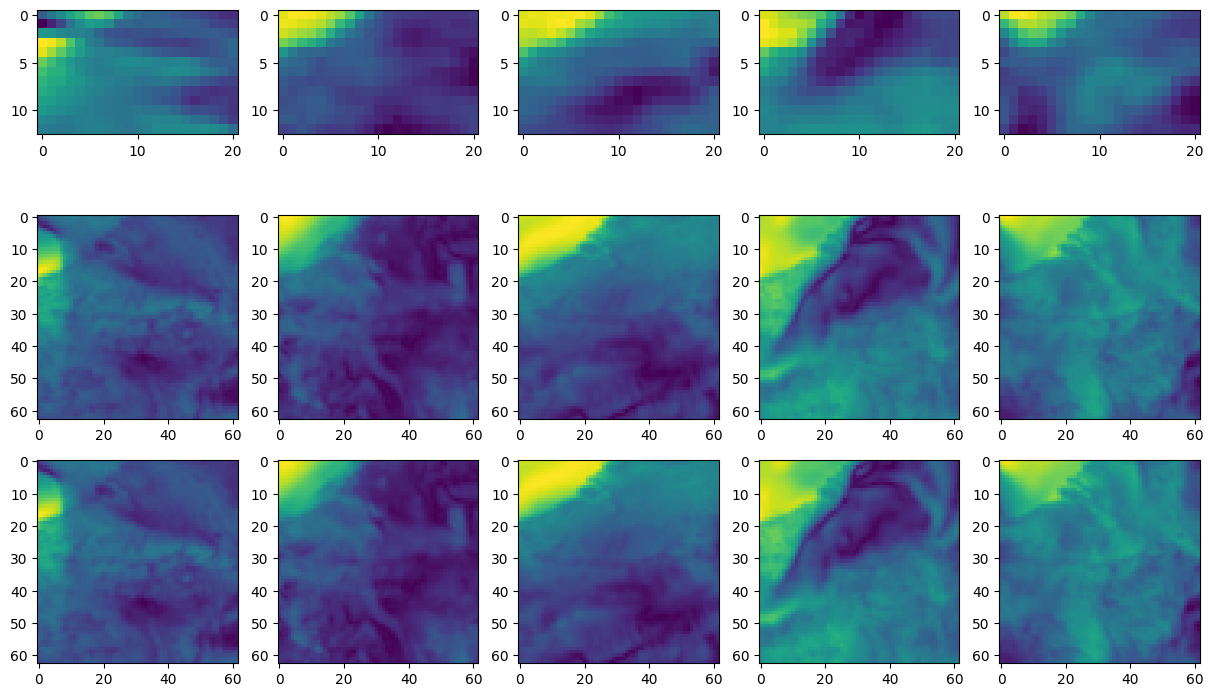

In [17]:
batch = next(iter(train_data_loader))
x = batch['low_res'][:5]
y = batch['high_res'][:5]

fig, axs = plt.subplots(3, 5, figsize=(15, 9))

for i in range(5):
    axs[0, i].imshow(x[i].squeeze().numpy())
for i in range(5):
    tmp = np.flipud(y[i].squeeze())
    axs[1, i].imshow(tmp)
for i in range(5):
    tmp = np.flipud(y[i].squeeze()).copy()
    tmp = tmp * (out_max - out_min) + out_min
    axs[2, i].imshow(tmp)


In [18]:
def callback_lr_wd(optimizer, epoch, num_epochs):
    '''Callback function that adjusts both the learning rate and weight decay'''
    lr = 1e-04 * (0.1 ** (epoch / num_epochs)) # Learning rate decay from 1e-04 to 1e-05
    wd = 1e-05 * (0.1 ** (epoch / num_epochs)) # Weight decay decay from 1e-05 to 1e-06
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
        param_group['weight_decay'] = wd

In [19]:
# Let's try to implement the parts of the training loop before combining everything together
import torch.nn.functional as F

num_epochs = 100

wandb.init(
    # set the wandb project where this run will be logged
    project="Wind_Downscaling",

    # track hyperparameters and run metadata
    config={
    "architecture": "UNet-diffuse",
    "channels": "T",
    "dataset": "2010-2020",
    "normalize": "True",
    "learning_rate": lr,
    "epochs": num_epochs
    },
    
    name="MSE_paramsLikePaper"
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/smokeddem/anaconda3/envs/Weather/lib/python3.12/site-packages/wandb/__main__.py", line 3, in <module>
    cli.cli(prog_name="python -m wandb")
  File "/home/smokeddem/anaconda3/envs/Weather/lib/python3.12/site-packages/click/core.py", line 1157, in __call__
    return self.main(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/smokeddem/anaconda3/envs/Weather/lib/python3.12/site-packages/click/core.py", line 1078, in main
    rv = self.invoke(ctx)
         ^^^^^^^^^^^^^^^^
  File "/home/smokeddem/anaconda3/envs/Weather/lib/python3.12/site-packages/click/core.py", line 1688, in invoke
    return _process_result(sub_ctx.command.invoke(sub_ctx))
                           ^^^^^^^^

AssertionError: 

In [ ]:
for epoch in tqdm(range(num_epochs)):
    callback_lr_wd(optimizer, epoch, num_epochs)

    model.train()
    total_loss = 0.0
    total_batches = 0

    for i, batch in enumerate(train_data_loader):
        optimizer.zero_grad()

        high_res_imgs = batch["high_res"]
        high_res_imgs = high_res_imgs.unsqueeze(1) # because one channel

        if high_res_imgs.shape[0] != batch_size:
            t = torch.randint(0, T, (high_res_imgs.shape[0],), device=device).long()
        else :
            t = torch.randint(0, T, (batch_size,), device=device).long() # En gros, si le dernier batch est plus petit faut faire ca pour que le input de forward difusion soit de même taille

        # apply noise
        noisy_x, noise = forward_diffusion_sample(high_res_imgs, t)

        noisy_x = noisy_x.float()

        # For now, let's only condition on low res at the same time, to simplify implementation
        low_res_imgs = batch["low_res"]
        low_res_imgs = low_res_imgs.unsqueeze(1).float() # because one channel

        # upsample low res to match high res shape
        upsampled = F.interpolate(low_res_imgs, size=up_shape, mode='bilinear')

        unet_input = torch.cat((noisy_x, upsampled), dim=1)

        noise_pred = model(unet_input.to(device), t) # model is denoising unet

        noise = noise.to(device)
        loss = F.mse_loss(noise, noise_pred) # before: l1_loss

        total_loss += loss.item()
        total_batches += 1

        loss.backward()
        optimizer.step()
    average_loss = total_loss/total_batches
    wandb.log({"loss": average_loss, "epoch":epoch})

    # test part

    model.eval()
    with torch.no_grad(): # not sure needed since we use model.eval() but I guess it cannot harm
        test_loss = 0.0
        test_batches = 0

        for i, batch in enumerate(test_data_loader):

            high_res_imgs = batch["high_res"]
            high_res_imgs = high_res_imgs.unsqueeze(1) # because one channel

            if high_res_imgs.shape[0] != batch_size:
                t = torch.randint(0, T, (high_res_imgs.shape[0],), device=device).long()
            else :
                t = torch.randint(0, T, (batch_size,), device=device).long()

            # apply noise
            noisy_x, noise = forward_diffusion_sample(high_res_imgs, t)

            noisy_x = noisy_x.float()

            # For now, let's only condition on low res at the same time, to simplify implementation
            low_res_imgs = batch["low_res"]
            low_res_imgs = low_res_imgs.unsqueeze(1).float() # because one channel

            # upsample low res to match high res shape
            upsampled = F.interpolate(low_res_imgs, size=up_shape, mode='bilinear')

            unet_input = torch.cat((noisy_x, upsampled), dim=1)

            noise_pred = model(unet_input.to(device), t) # model is denoising unet

            noise = noise.to(device)
            loss = F.mse_loss(noise, noise_pred) # before: l1_loss

            test_loss += loss.item()
            test_batches += 1

        average_test_loss = test_loss/test_batches
        wandb.log({"test_loss": average_test_loss, "epoch":epoch})

    if epoch % 5 == 0:
        print(f"Epoch = {epoch+1}/{num_epochs}.")
        print(f"Training Loss over the last epoch = {average_loss}")
        print(f"Test Loss over the last epoch = {average_test_loss}")

  1%|          | 1/100 [00:58<1:35:44, 58.03s/it]

Epoch = 1/100.
Training Loss over the last epoch = 1.0014093964985997
Test Loss over the last epoch = 0.9993316171273507


  3%|▎         | 3/100 [02:40<1:25:03, 52.61s/it]

In [ ]:
# Save the model, j'ai vu que c'était mieux de save comme ca pour éviter tout problème de compatibilité

def save_model(model, optimizer, path):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, path)

save_model(model, optimizer, 'diffusion_model_wind.pth')


# Inference Part

In [20]:
# Loading (comme ca on doit pas tout run avant et on peut comparer nos différents models rapidement sur le test set)

def load_model(model, optimizer, path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

load_model(model, optimizer, 'diffusion_model_wind.pth')

In [ ]:
# Inference

model.eval()
with torch.no_grad():
    val_loss = 0.0
    val_batches = 0

    for i, batch in enumerate(train_data_loader):
        high_res_imgs = batch["high_res"]
        high_res_imgs = high_res_imgs.unsqueeze(1) # because one channel

        if high_res_imgs.shape[0] != batch_size:
            t = torch.randint(0, T, (high_res_imgs.shape[0],), device=device).long()
        else :
            t = torch.randint(0, T, (batch_size,), device=device).long()

        # apply noise
        noisy_x, noise = forward_diffusion_sample(high_res_imgs, t)

        noisy_x = noisy_x.float()

        # For now, let's only condition on low res at the same time, to simplify implementation
        low_res_imgs = batch["low_res"]
        low_res_imgs = low_res_imgs.unsqueeze(1).float() # because one channel

        # upsample low res to match high res shape
        upsampled = F.interpolate(low_res_imgs, size=up_shape, mode='bilinear')

        unet_input = torch.cat((noisy_x, upsampled), dim=1)

        noise_pred = model(unet_input.to(device), t) # model is denoising unet

        noise = noise.to(device)
        loss = F.mse_loss(noise, noise_pred) # before: l1_loss

        val_loss += loss.item()
        val_batches += 1

    average_val_loss = val_loss / val_batches
    print(f'Validation Loss: {average_val_loss}')


In [ ]:
##########################################################################################
# DDPM Mode
##########################################################################################

In [21]:
import matplotlib.pyplot as plt

In [22]:
model.to('cpu')
model.eval()

DenoisingUnet(
  (down0): DownBlock(
    (conv1): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (bnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop): Dropout(p=0.5, inplace=False)
    (relu): ReLU()
    (avgpool): AvgPool2d(kernel_size=6, stride=2, padding=2)
    (time_mlp): Linear(in_features=32, out_features=64, bias=True)
  )
  (downs): ModuleList(
    (0): DownBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop): Dropout(p=0.5, in

In [23]:
batch = next(iter(train_data_loader))

In [24]:
batch_size = 3 # Simpler plot + faster computations, can change that back later
batch["low_res"] = batch["low_res"][:batch_size]
batch['high_res'] = batch['high_res'][:batch_size]

In [69]:
low_res_imgs = batch["low_res"].unsqueeze(1)
upsampled = F.interpolate(low_res_imgs, size=up_shape, mode='bilinear')

n_steps = 5

all_x_t = []

x_t = torch.randn((batch_size, 1, batch["high_res"][0].shape[0], batch["high_res"][0].shape[1]))
all_x_t.append(x_t)
for i in range(T-1, -1, -1):
    t = torch.tensor([i for _ in range(batch_size)], device='cpu').long()
    
    unet_input = torch.cat((x_t, upsampled), dim=1)
    unet_input = unet_input.float()

    betas_t = get_index_from_list(betas, t, x_t.shape)

    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x_t.shape)

    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x_t.shape)
    # print(sqrt_recip_alphas_t)

    with torch.no_grad():
        x_t_minus_1 = sqrt_recip_alphas_t * (x_t - betas_t * model(unet_input, t) / sqrt_one_minus_alphas_cumprod_t)
        # print(x_t_minus_1)

        posterior_variance_t = get_index_from_list(posterior_variance, t, x_t.shape)

        if i == 0:
            x_t = x_t_minus_1
        else:
            noise = torch.randn_like(x_t)
            x_t = x_t_minus_1 + torch.sqrt(posterior_variance_t) * noise
            print(x_t)
            # print(torch.sqrt(posterior_variance_t))
            
        if i % (T/n_steps) == 0:
            print(f'Step {i+1}')
            all_x_t.append(x_t)

tensor([[[[ 6.0314, -4.7061, -0.2312,  ...,  7.4194,  1.3305, -1.6085],
          [-5.8157,  2.8288, -5.6109,  ..., -5.5159, -0.7365, -0.0618],
          [ 2.4883, -0.8606, -0.3592,  ...,  7.5005,  2.9975,  0.6642],
          ...,
          [ 1.5868,  5.2095, -8.4619,  ..., -2.1469, -0.8421, -2.0010],
          [-1.3688,  1.5365, -2.2202,  ...,  0.7169,  1.6632, -1.7482],
          [ 3.5794,  0.5242, -1.0278,  ...,  0.1725, -2.2229,  0.6580]]]])
tensor([[[[ 1.9445e+01, -1.4316e+01,  3.7721e+00,  ...,  2.1240e+01,
            2.6391e+00, -5.1958e+00],
          [-1.8977e+01,  1.0441e+01, -1.4376e+01,  ..., -2.0200e+01,
           -5.6608e+00,  3.7333e-01],
          [ 7.0284e+00, -4.8527e+00, -2.7077e+00,  ...,  2.4883e+01,
            7.0125e+00,  2.6768e+00],
          ...,
          [ 3.7998e+00,  1.3197e+01, -2.4225e+01,  ..., -9.1256e+00,
            1.7394e-02, -5.2431e+00],
          [-7.8933e+00,  2.7054e+00, -3.7106e+00,  ...,  4.0955e+00,
            9.1005e+00, -1.3571e-01],


In [65]:
all_x_t[1][0].squeeze()

tensor([[ 2.0466e+01,  4.2498e+01, -5.2149e+23,  ..., -5.2913e+24,
         -1.4072e+25, -9.7510e+24],
        [-1.3410e+02, -6.8253e+24, -7.1655e+24,  ..., -2.7457e+25,
         -3.5513e+25, -2.0309e+25],
        [-1.0800e+24, -1.3628e+25, -8.2771e+24,  ..., -2.4898e+25,
         -3.1092e+25, -1.6734e+25],
        ...,
        [-9.9739e+20, -1.6027e+21, -1.8052e+11,  ..., -1.0464e+02,
          1.0980e+02,  3.7113e+01],
        [-4.4134e+20, -7.0058e+20,  8.8899e+01,  ...,  1.3070e+02,
         -1.0937e+02, -8.3253e+01],
        [-2.0375e+20, -2.8669e+20, -5.9497e+01,  ...,  1.0572e+02,
         -8.2728e+01,  9.7308e+01]])

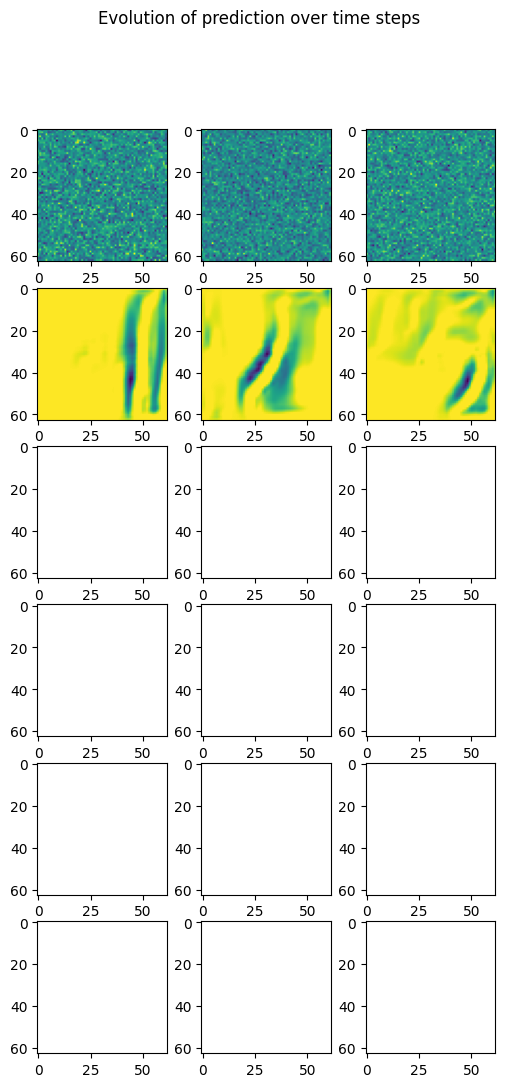

In [26]:
fig, axs = plt.subplots(len(all_x_t), batch_size, figsize=(6, 12))

fig.suptitle("Evolution of prediction over time steps")

for i in range(len(all_x_t)):
    for j in range(batch_size):
        axs[i, j].imshow(all_x_t[i][j].squeeze().numpy())

In [ ]:
# Permet de visualiser les différents inputs, etc.

import matplotlib.pyplot as plt


def plot_windspeeds(ax, windspeeds, title):
    """
    Plot windspeeds

    Parameters:
        ax (matplotlib.axes): The axis to plot on.
        windspeeds (torch.Tensor): Tensor representing windspeeds in a grid.
        title (str): The title of the subplot.
    """
    # Convert the windspeeds tensor to a NumPy array
    windspeeds_array = windspeeds.numpy()

    # Plot the windspeeds using imshow
    im = ax.imshow(windspeeds_array, cmap='viridis', origin='lower')
    ax.figure.colorbar(im, ax=ax, label='Windspeed')
    ax.set_title(title)
    ax.set_xlabel('Horizontal Index')
    ax.set_ylabel('Vertical Index')


model.to('cpu')

fig, axes = plt.subplots(1, 5, figsize=(25, 5))

batch = next(iter(train_data_loader))  # Prend le premier batch

low_res_imgs = batch["low_res"].unsqueeze(1)
upsampled = F.interpolate(low_res_imgs, size=up_shape, mode='bilinear')

inference_step = 10

t = torch.tensor([T-1 for _ in range(batch_size)], device='cpu').long()

noisy_x = torch.randn((batch_size, 1, batch["high_res"][0].shape[0], batch["high_res"][0].shape[1]))

unet_input = torch.cat((noisy_x, upsampled), dim=1)
unet_input = unet_input.float()

with torch.no_grad():
    predicted_noise = model(unet_input, t)
    
for i in range(1, inference_step+1):
    t = torch.tensor([(T/i)-1 for _ in range(batch_size)], device='cpu').long()
    unet_input = torch.cat((predicted_noise, upsampled), dim=1)
    unet_input = unet_input.float()
    with torch.no_grad():
        predicted_noise = model(unet_input, t)
    
predicted_image = noisy_x - predicted_noise
plt.figure(figsize=(10,20))
plot_windspeeds(axes[0], low_res_imgs[0].squeeze(), "Low resolution input")
plot_windspeeds(axes[1], upsampled[0].squeeze(), "Upsampled low resolution input")
plot_windspeeds(axes[2], batch["high_res"][0], "True high resolution")
plot_windspeeds(axes[3], noisy_x[0].squeeze(), "After applying noise")
plot_windspeeds(axes[4], predicted_image[0].squeeze(), "Predicted image")
plt.tight_layout()
plt.show()


In [ ]:
##########################################################################################
# DDIM Mode
##########################################################################################

In [20]:
import matplotlib.pyplot as plt

In [21]:
model.to('cpu') # Why CPU?
model.eval()

DenoisingUnet(
  (down0): DownBlock(
    (conv1): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (bnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (avgpool): AvgPool2d(kernel_size=6, stride=2, padding=2)
    (time_mlp): Linear(in_features=32, out_features=64, bias=True)
  )
  (downs): ModuleList(
    (0): DownBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (avgpool): AvgPool2d(kernel_size=6, stride=2, 

In [50]:
batch = next(iter(train_data_loader))

In [51]:
batch_size = 1
batch["low_res"] = batch["low_res"][:batch_size]
batch['high_res'] = batch['high_res'][:batch_size]

In [72]:
low_res_imgs = batch["low_res"].unsqueeze(1)
# print(low_res_imgs)
# print('-------')
upsampled = F.interpolate(low_res_imgs, size=up_shape, mode='bilinear')
# print(upsampled)
# print('-------')

n_steps = 5

all_x_t = []

x_t = torch.randn((batch_size, 1, batch["high_res"][0].shape[0], batch["high_res"][0].shape[1]))
all_x_t.append(x_t)

# print('ITERATIONS')
# print('-------')
for i in range(T-1, -1, -1):
    t = torch.tensor([i for _ in range(batch_size)], device='cpu').long()
    
    # print(x_t)
    # print('-------')
    
    unet_input = torch.cat((x_t, upsampled), dim=1)
    unet_input = unet_input.float()
    
    # print(unet_input)
    # print('-------')
    
    with torch.no_grad():
        predicted_noise = model(unet_input, t) 
        
        # print(predicted_noise)
        # print('-------')
        
        predicted_x0 = get_index_from_list((1.0 / sqrt_alphas_cumprod), t, x_t.shape) * \
        (x_t - get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x_t.shape) * predicted_noise)
        
        print(get_index_from_list((1.0 / sqrt_alphas_cumprod), t, x_t.shape))
        
        t_minus_1 = t - 1
        
        if i == 0:
            x_t = predicted_x0
        else:
            x_t = get_index_from_list(sqrt_alphas_cumprod, t_minus_1, x_t.shape) * predicted_x0 + \
            get_index_from_list(sqrt_one_minus_alphas_cumprod, t_minus_1, x_t.shape) * predicted_noise
        
        if i % (T/n_steps) == 0:
            print(f'Step {i+1}')
            all_x_t.append(x_t)
        break

tensor([[[[7479.4282]]]])
tensor([[[[ 2.9917, -1.1700, -0.0248,  ..., -5.5712, -2.9605,  1.2642],
          [-1.5166,  6.0226,  2.6710,  ..., -3.3273, -3.1778,  3.1246],
          [-1.6098, 10.3374, -0.9584,  ...,  1.9089,  9.4028, -2.2762],
          ...,
          [ 6.9193, -2.3985, -2.8198,  ...,  9.6502,  2.6540, -0.4177],
          [-0.0193,  0.9803, -1.3657,  ...,  3.6702, -5.5657,  1.0163],
          [ 1.7942,  1.3821,  0.2201,  ...,  0.5168,  1.1331,  0.5308]]]])


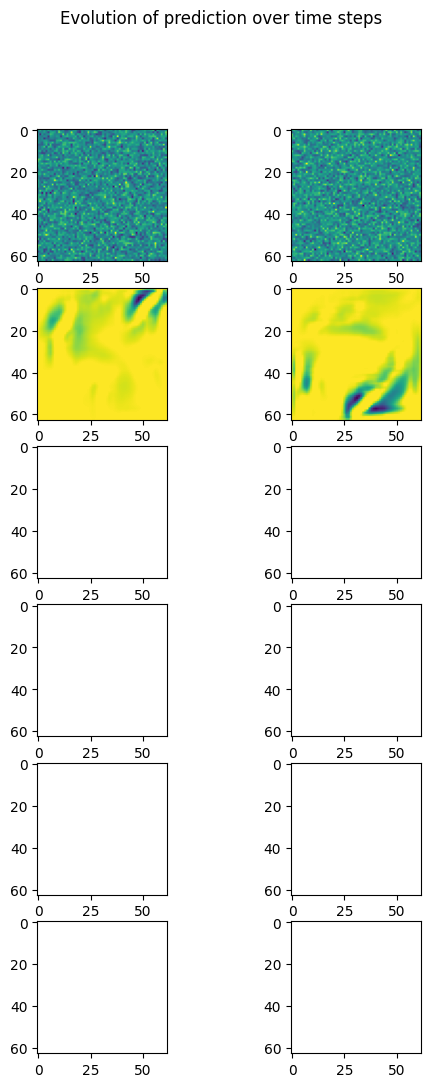

In [49]:
fig, axs = plt.subplots(len(all_x_t), batch_size, figsize=(6, 12))

fig.suptitle("Evolution of prediction over time steps")

for i in range(len(all_x_t)):
    for j in range(batch_size):
        axs[i, j].imshow(all_x_t[i][j].squeeze().numpy())